# The `tub-north` simulations

This notebook contains preliminary analysis for the `tub-north` simulations. These simulations use a northern hemisphere sector domain to test buoyancy wind-driven gyres in MOM6. Wind forcing is achieved through a zonal wind stress that has maximum value ($\tau_0$) at mid-latitudes. Thermal forcing is achieved by restoring towards a prescribed SST profile, at a rate proportional to `FLUXCONST`. The southern boundary and upper several hundred meters have elevated diffusivity.

#### The code in this notebook assumes that `ProcessData.ipynb` has been used to generate averaged and timeseries netcdf files ready to plot.

## Cases run so far
| Run name | wind: $\tau_0$ | `FLUXCONST` | Notes 
|----------|----------|-----------|------
| `tub-north-tx01-fc02` | 0.1 | 0.2 | **Reference case.**
|----------|----------|-----------|------
| `tub-north-tx00-fc02` | 0.0 | 0.2 | Reference buoyancy, No wind. Run from year 0.
| `tub-north-tx00-fc02-pert` | 0.0 | 0.2 | As above, but split from reference at year 1000.
| `tub-north-tx005-fc02` | 0.05 | 0.2 | Weak wind, split from reference at year 1000.
| `tub-north-tx02-fc02` | 0.2 | 0.2 | Strong wind, split from reference at year 1000.
|----------|----------|-----------|------
| `tub-north-tx01-fc00` | 0.1 | 0.0 | No buoyancy flux, split from reference at year 1000.
| `tub-north-tx01-fc005` | 0.1 | 0.05 | Weaker buoyancy flux, split from reference at year 1000.
| `tub-north-tx01-fc01` | 0.1 | 0.1 | Weaker buoyancy flux, split from reference at year 1000.
| `tub-north-tx01-fc03` | 0.1 | 0.3 | Stronger buoyancy flux, split from reference at year 1000.
|----------|----------|-----------|------
| `tub-north-GM-1deg` | 0.1 | 0.2 | Reference forcing, 1° resolution, with GM on.
| `tub-north-GM-1deg-tx00` | 0.0 | 0.2 | No wind forcing, 1° resolution, with GM on.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [14]:
db='/home/157/amh157/tub-north/tub-north.db'
exptdict = OrderedDict([
    ('tx01-fc00',   {'expt':'tub-north-tx01-fc00','start_time':'1100-01-01'}),
    ('tx01-fc005',   {'expt':'tub-north-tx01-fc005','start_time':'1100-01-01'}),
    ('tx01-fc01',   {'expt':'tub-north-tx01-fc01','start_time':'1100-01-01'}),
    ('tx01-fc03',   {'expt':'tub-north-tx01-fc03','start_time':'1100-01-01'}),
    ('tx00-fc02',   {'expt':'tub-north-tx00-fc02','start_time':'1100-01-01'}),
    ('tx00-fc02-pert',   {'expt':'tub-north-tx00-fc02-pert','start_time':'1100-01-01'}),
    ('tx005-fc02',   {'expt':'tub-north-tx005-fc02','start_time':'1100-01-01'}),
    ('tx01-fc02',   {'expt':'tub-north-tx01-fc02','start_time':'1100-01-01'}),
    ('tx02-fc02',   {'expt':'tub-north-tx02-fc02','start_time':'1100-01-01'}),
    ('GM',   {'expt':'tub-north-GM-1deg','start_time':'1100-01-01'}),
    ('GM-tx00',   {'expt':'tub-north-GM-1deg-tx00','start_time':'1100-01-01'})
])
wind_expts = ['tx00-fc02-pert','tx005-fc02','tx01-fc02','tx02-fc02']
wind = [0, 0.05, 0.1, 0.2]
buoy_expts = ['tx01-fc00','tx01-fc005','tx01-fc01','tx01-fc02','tx01-fc03']
buoyancy = [0, 0.05, 0.1, 0.2, 0.3]
GM_expts = ['tx01-fc02','tx00-fc02','GM','GM-tx00']
processed = '/g/data/v45/amh157/tub-north-processed/'

# Plotting
This function is for plotting fields on a grid that roughly scales the plot gridcells by their area.



In [3]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[10.1, 10.1],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=10,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

## Mixed Layer Depth

This model creates deep convective mixed layers in the subpolar gyre, in line with the simplified convective physics and forcing. Mixed layer depth shoals a little with stronger wind stress (and with the addition of GM) presumably because the horizontal fluxes from eddies counteracts the convection. Mixed layers deepen with enhanced buoyancy flux, as expected.

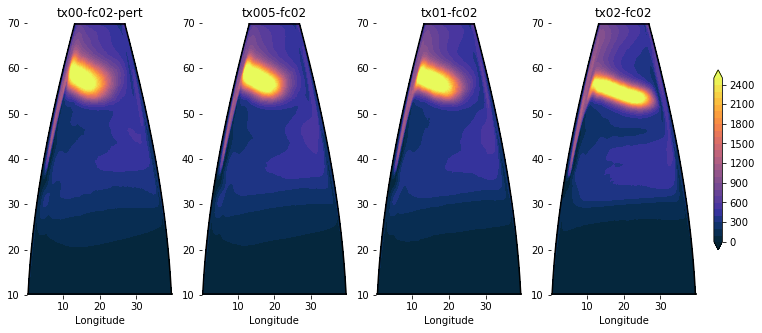

In [5]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,2500,26)
variable = 'mlotst'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst
    X,Y = plot_mercator(ax[ii],MLD.coords['xh'],MLD.coords['yh'])
    p1=ax[ii].contourf(X,Y,MLD,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

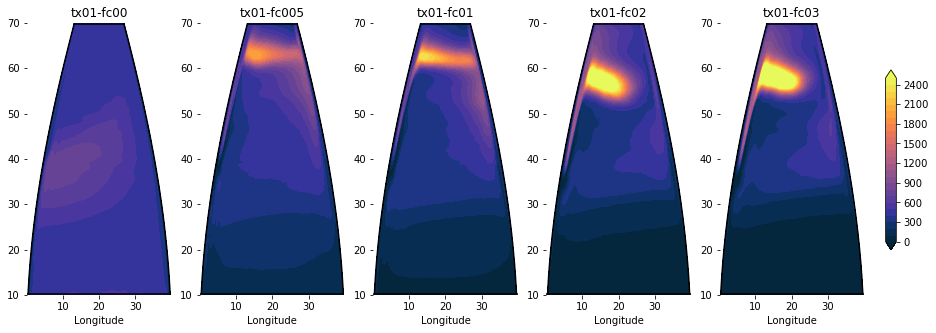

In [6]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(0,2500,26)
variable = 'mlotst'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst
    X,Y = plot_mercator(ax[ii],MLD.coords['xh'],MLD.coords['yh'])
    p1=ax[ii].contourf(X,Y,MLD,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

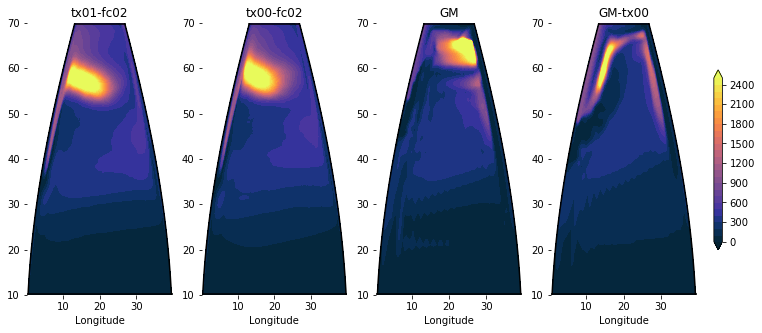

In [39]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,2500,26)
variable = 'mlotst'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst
    X,Y = plot_mercator(ax[ii],MLD.coords['xh'],MLD.coords['yh'])
    p1=ax[ii].contourf(X,Y,MLD,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,0,'Buoyancy Forcing')

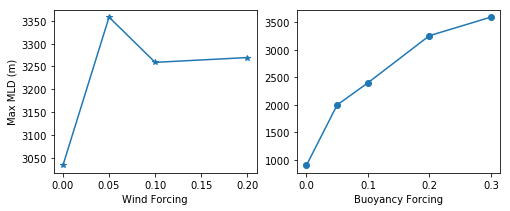

In [15]:
# Max MLD
plt.figure(figsize=(8,3))
variable = 'mlotst'

MLDvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst.max()
    MLDvec = np.append(MLDvec,MLD)
plt.subplot(121)
plt.plot(wind,MLDvec,'*-',label='wind')  
plt.ylabel('Max MLD (m)')
plt.xlabel('Wind Forcing')
         
MLDvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst.max()
    MLDvec = np.append(MLDvec,MLD)
plt.subplot(122)
plt.plot(buoyancy,MLDvec,'o-',label='buoyancy') 
plt.ylabel('')
plt.xlabel('Buoyancy Forcing')

Text(0.5,1,'(c) GM Expts')

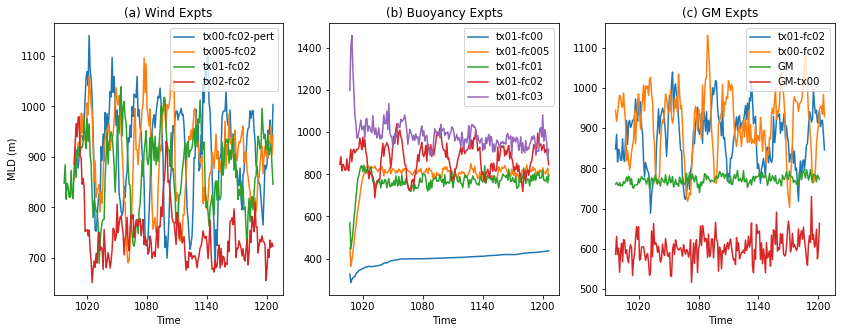

In [65]:
# Timeseries of mean MLD north of 55N
plt.figure(figsize=(14,5))
variable = 'mlotst'
plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_timeseries.nc'
    MLD = xr.open_dataset(FileName).mlotst
    MLD.plot(label=ekey)  
plt.legend()
plt.ylabel('MLD (m)')
plt.title('(a) Wind Expts')
plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_timeseries.nc'
    MLD = xr.open_dataset(FileName).mlotst
    MLD.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(b) Buoyancy Expts')
plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_timeseries.nc'
    MLD = xr.open_dataset(FileName).mlotst
    MLD.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(c) GM Expts')

## Heat Flux


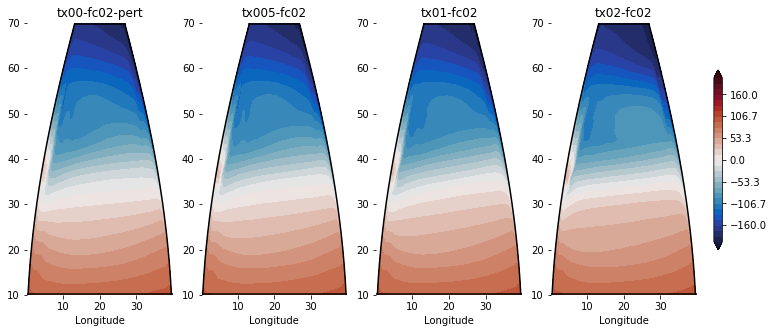

In [9]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-200,200,31)
variable = 'heat_added'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    HF = xr.open_dataset(FileName).heat_added
    X,Y = plot_mercator(ax[ii],HF.coords['xh'],HF.coords['yh'])
    p1=ax[ii].contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

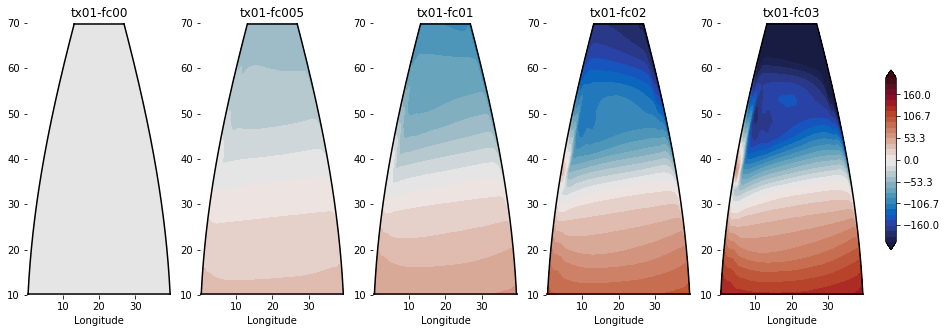

In [10]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-200,200,31)
variable = 'heat_added'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    HF = xr.open_dataset(FileName).heat_added
    X,Y = plot_mercator(ax[ii],HF.coords['xh'],HF.coords['yh'])
    p1=ax[ii].contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

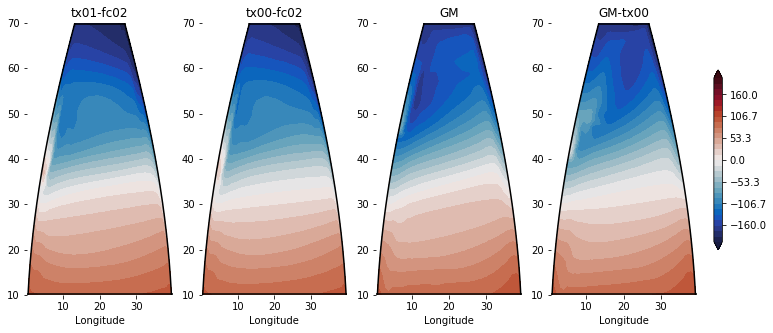

In [41]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-200,200,31)
variable = 'heat_added'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    HF = xr.open_dataset(FileName).heat_added
    X,Y = plot_mercator(ax[ii],HF.coords['xh'],HF.coords['yh'])
    p1=ax[ii].contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(d) Heat flux over subtropical gyre')

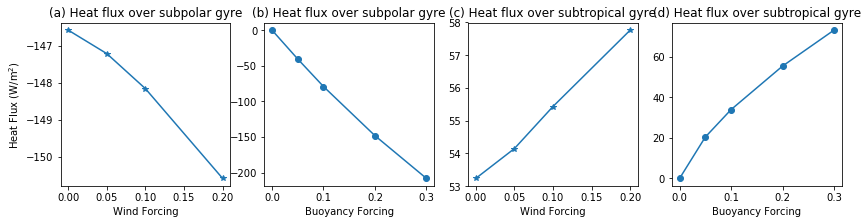

In [26]:
# HEat flux north of 50°N
plt.figure(figsize=(14,3))
variable = 'heat_added'

plt.subplot(141)
HeatFluxvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added.mean()
    HeatFluxvec = np.append(HeatFluxvec,HFn)
plt.plot(wind,HeatFluxvec,'*-',label='wind')  
plt.ylabel('Heat Flux (W/m$^2$)')
plt.xlabel('Wind Forcing')
plt.title('(a) Heat flux over subpolar gyre')


plt.subplot(142)
HeatFluxvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added.mean()
    HeatFluxvec = np.append(HeatFluxvec,HFn)
plt.plot(buoyancy,HeatFluxvec,'o-',label='buoyancy')  
FileName = processed+'/'+variable+'_north_avge.npy'
np.save(FileName, HeatFluxvec)

plt.ylabel('')
plt.xlabel('Buoyancy Forcing')
plt.title('(b) Heat flux over subpolar gyre')

# HEat flux over 10-30°N
plt.subplot(143)
variable = 'heat_added'

HeatFluxvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added.mean()
    HeatFluxvec = np.append(HeatFluxvec,HFn)
plt.plot(wind,HeatFluxvec,'*-',label='wind')  
plt.xlabel('Wind Forcing')
plt.title('(c) Heat flux over subtropical gyre')

plt.subplot(144)
HeatFluxvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added.mean()
    HeatFluxvec = np.append(HeatFluxvec,HFn)
plt.plot(buoyancy,HeatFluxvec,'o-',label='buoyancy') 
FileName = processed+'/'+variable+'_south_avge.npy'
np.save(FileName, HeatFluxvec) 

#plt.legend()
plt.ylabel('')
plt.xlabel('Buoyancy Forcing')
plt.title('(d) Heat flux over subtropical gyre')

Text(0.5,1,'(f) GM Expts: Subtropical')

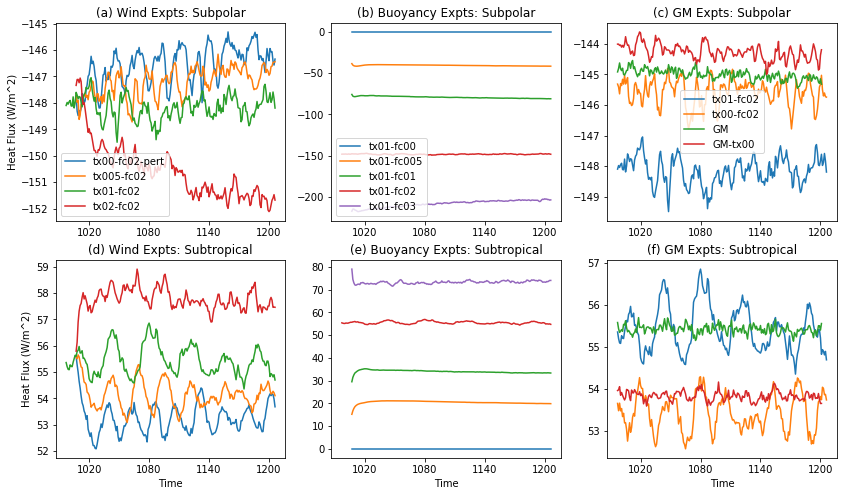

In [67]:
fig,ax = plt.subplots(2,3,figsize=(14,8))
variable = 'heat_added'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added
    HFn.plot(ax=ax[0,0], label=ekey)
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFs = xr.open_dataset(FileName).heat_added
    HFs.plot(ax=ax[1,0],label=ekey)

for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added
    HFn.plot(ax=ax[0,1], label=ekey)
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFs = xr.open_dataset(FileName).heat_added
    HFs.plot(ax=ax[1,1],label=ekey)

    
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added
    Time = cftime.date2num(HFn.Time,units='days since 0001-01-01',calendar='julian')/365
    HFn.plot(ax=ax[0,2], label=ekey)
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFs = xr.open_dataset(FileName).heat_added
    HFs.plot(ax=ax[1,2],label=ekey)
    
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[0,0].set_ylabel('Heat Flux (W/m^2)')
ax[1,0].set_ylabel('Heat Flux (W/m^2)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,2].set_ylabel('')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,0].set_title('(a) Wind Expts: Subpolar')
ax[0,1].set_title('(b) Buoyancy Expts: Subpolar')
ax[0,2].set_title('(c) GM Expts: Subpolar')
ax[1,0].set_title('(d) Wind Expts: Subtropical')
ax[1,1].set_title('(e) Buoyancy Expts: Subtropical')
ax[1,2].set_title('(f) GM Expts: Subtropical')

## SSH

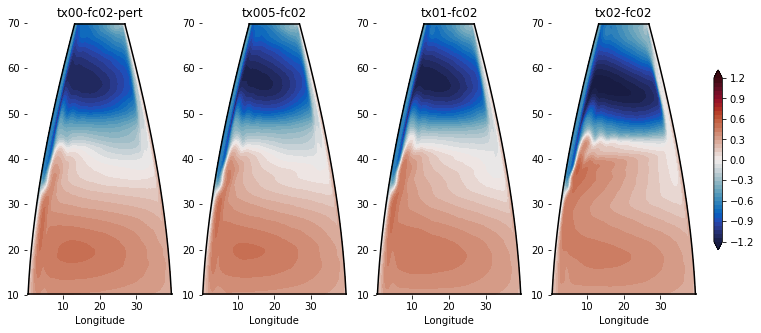

In [13]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-1.2,1.2,41)
variable = 'SSH'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSH = xr.open_dataset(FileName).SSH
    X,Y = plot_mercator(ax[ii],SSH.coords['xh'],SSH.coords['yh'])
    p1=ax[ii].contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

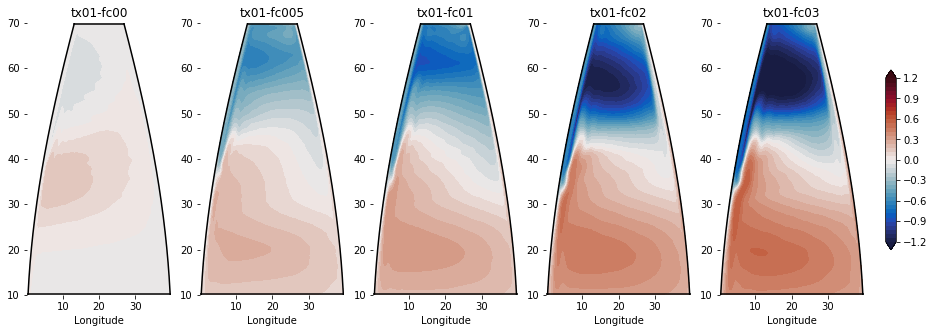

In [14]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-1.2,1.2,41)
variable = 'SSH'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSH = xr.open_dataset(FileName).SSH
    X,Y = plot_mercator(ax[ii],SSH.coords['xh'],SSH.coords['yh'])
    p1=ax[ii].contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

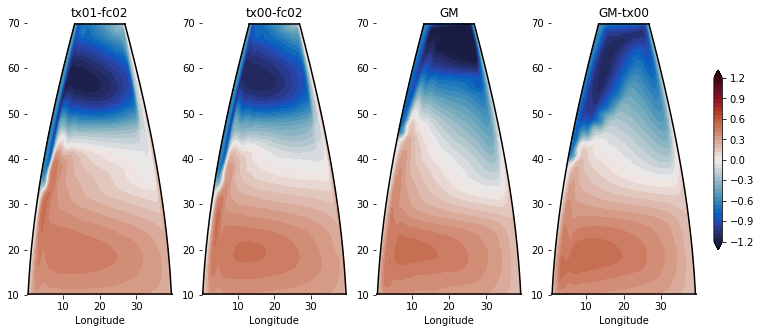

In [43]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-1.2,1.2,41)
variable = 'SSH'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSH = xr.open_dataset(FileName).SSH
    X,Y = plot_mercator(ax[ii],SSH.coords['xh'],SSH.coords['yh'])
    p1=ax[ii].contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(d) Min SSH at 10°E')

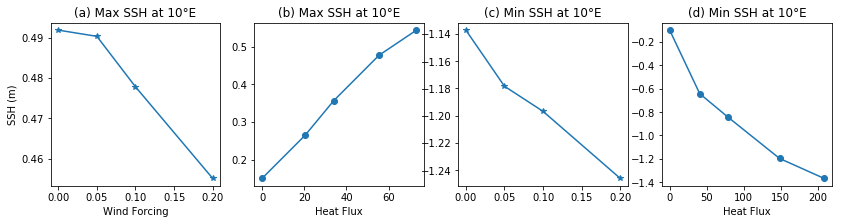

In [31]:
# Max SSH at 10°E
plt.figure(figsize=(14,3))
variable = 'SSH'

plt.subplot(141)
SSHvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSHmax = xr.open_dataset(FileName).SSH.sel(xh=10,method='nearest').max()
    SSHvec = np.append(SSHvec,SSHmax)
plt.plot(wind,SSHvec,'*-',label='wind') 
plt.ylabel('SSH (m)')
plt.xlabel('Wind Forcing')
plt.title('(a) Max SSH at 10°E') 
         
plt.subplot(142)
FileName = processed+'/'+'heat_added'+'_south_avge.npy'
HeatFluxvec = np.load(FileName)
SSHvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSHmax = xr.open_dataset(FileName).SSH.sel(xh=10,method='nearest').max()
    SSHvec = np.append(SSHvec,SSHmax)
plt.plot(HeatFluxvec,SSHvec,'o-',label='buoyancy')  

plt.ylabel('')
plt.xlabel('Heat Flux')
plt.title('(b) Max SSH at 10°E')

# Min SSH at 10°E
plt.subplot(143)
SSHvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSHmax = xr.open_dataset(FileName).SSH.sel(xh=10,method='nearest').min()
    SSHvec = np.append(SSHvec,SSHmax)
plt.plot(wind,SSHvec,'*-',label='wind')  
plt.title('(c) Min SSH at 10°E')
         

plt.subplot(144)
SSHvec=np.array([])
FileName = processed+'/'+'heat_added'+'_north_avge.npy'
HeatFluxvec = np.load(FileName)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSHmax = xr.open_dataset(FileName).SSH.sel(xh=10,method='nearest').min()
    SSHvec = np.append(SSHvec,SSHmax)
plt.plot(-HeatFluxvec,SSHvec,'o-',label='buoyancy')  

#plt.legend()
plt.ylabel('')
plt.xlabel('Heat Flux')
plt.title('(d) Min SSH at 10°E')

Text(0.5,1,'(f) GM Expts: SSH Maximum')

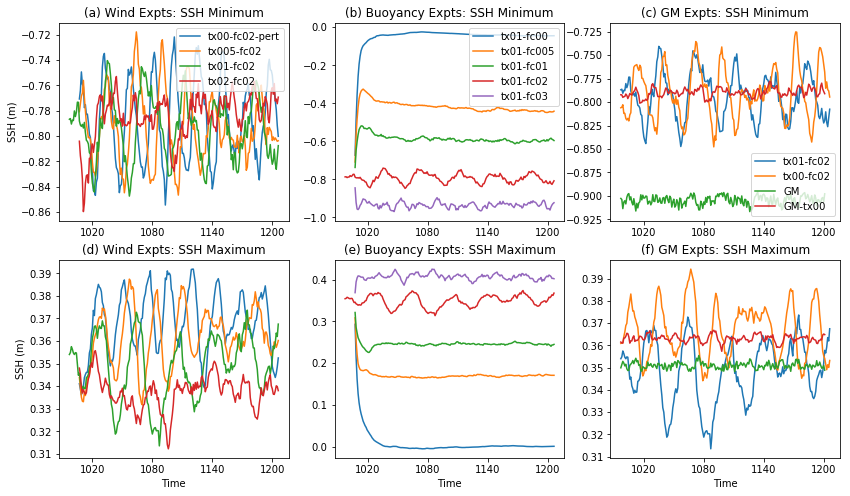

In [77]:
fig,ax = plt.subplots(2,3,figsize=(14,8))
variable = 'SSH'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_min_timeseries.nc'
    SSHmin = xr.open_dataset(FileName).SSH
    SSHmin.plot(ax=ax[0,0], label=ekey)
    FileName = processed+expt+'/'+variable+'_max_timeseries.nc'
    SSHmax = xr.open_dataset(FileName).SSH
    SSHmax.plot(ax=ax[1,0], label=ekey)

for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_min_timeseries.nc'
    SSHmin = xr.open_dataset(FileName).SSH
    SSHmin.plot(ax=ax[0,1], label=ekey)
    FileName = processed+expt+'/'+variable+'_max_timeseries.nc'
    SSHmax = xr.open_dataset(FileName).SSH
    SSHmax.plot(ax=ax[1,1], label=ekey)

for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_min_timeseries.nc'
    SSHmin = xr.open_dataset(FileName).SSH
    SSHmin.plot(ax=ax[0,2], label=ekey)
    FileName = processed+expt+'/'+variable+'_max_timeseries.nc'
    SSHmax = xr.open_dataset(FileName).SSH
    SSHmax.plot(ax=ax[1,2], label=ekey)
    
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[0,0].set_ylabel('SSH (m)')
ax[1,0].set_ylabel('SSH (m)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,2].set_ylabel('')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,0].set_title('(a) Wind Expts: SSH Minimum')
ax[0,1].set_title('(b) Buoyancy Expts: SSH Minimum')
ax[0,2].set_title('(c) GM Expts: SSH Minimum')
ax[1,0].set_title('(d) Wind Expts: SSH Maximum')
ax[1,1].set_title('(e) Buoyancy Expts: SSH Maximum')
ax[1,2].set_title('(f) GM Expts: SSH Maximum')

# SST

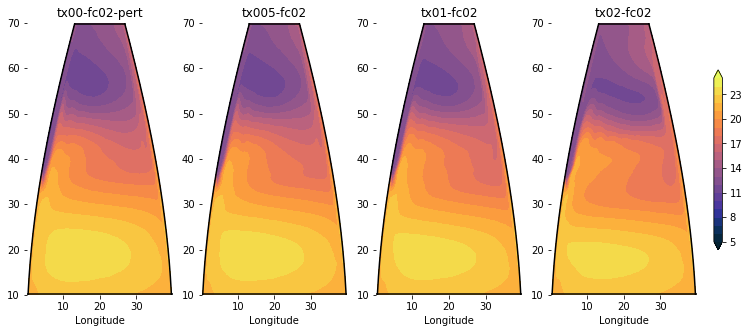

In [22]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(5,25,21)
variable = 'temp'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SST = xr.open_dataset(FileName).temp
    X,Y = plot_mercator(ax[ii],SST.coords['xh'],SST.coords['yh'])
    p1=ax[ii].contourf(X,Y,SST,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

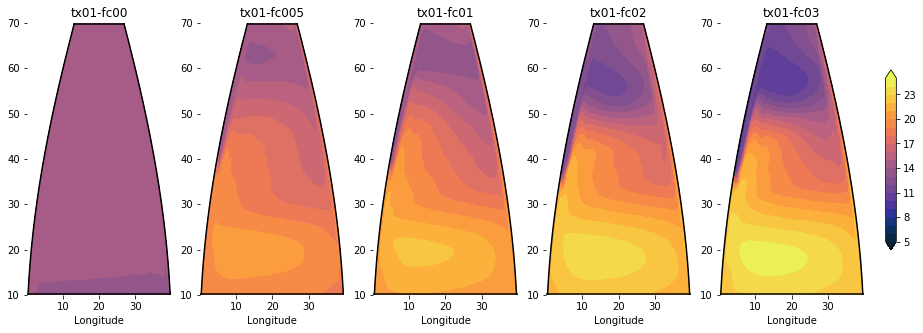

In [21]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(5,25,21)
variable = 'temp'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SST = xr.open_dataset(FileName).temp
    X,Y = plot_mercator(ax[ii],SST.coords['xh'],SST.coords['yh'])
    p1=ax[ii].contourf(X,Y,SST,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

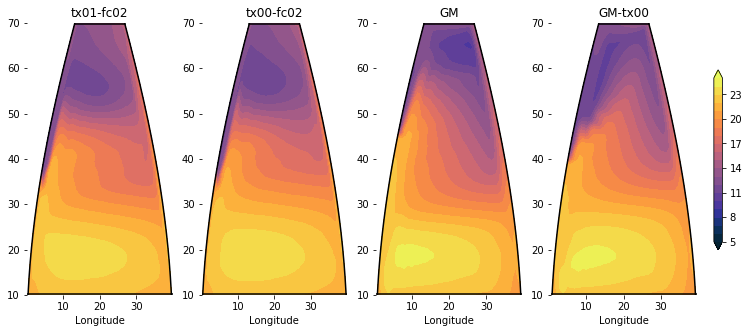

In [20]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(5,25,21)
variable = 'temp'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SST = xr.open_dataset(FileName).temp
    X,Y = plot_mercator(ax[ii],SST.coords['xh'],SST.coords['yh'])
    p1=ax[ii].contourf(X,Y,SST,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(b) Min SST at 10°E')

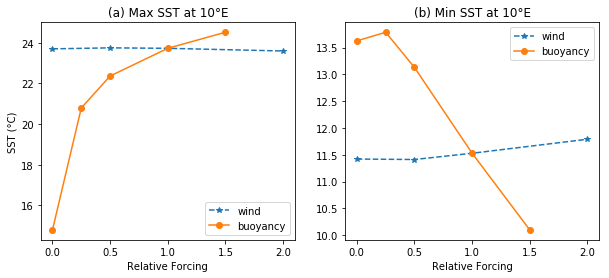

In [81]:
# Max SST at 10°E
plt.figure(figsize=(10,4))
plt.subplot(121)
variable = 'temp'

SSTvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SSTmax = xr.open_dataset(FileName).temp.sel(xh=10,method='nearest').max()
    SSTvec = np.append(SSTvec,SSTmax)
plt.plot(wind,SSTvec,'*--',label='wind')  
         

SSTvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SSTmax = xr.open_dataset(FileName).temp.sel(xh=10,method='nearest').max()
    SSTvec = np.append(SSTvec,SSTmax)
plt.plot(buoyancy,SSTvec,'o-',label='buoyancy')  

plt.legend()
plt.ylabel('SST (°C)')
plt.xlabel('Relative Forcing')
plt.title('(a) Max SST at 10°E')

# Min SSH at 10°E
plt.subplot(122)
variable = 'temp'

SSTvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SSTmax = xr.open_dataset(FileName).temp.sel(xh=10,method='nearest').min()
    SSTvec = np.append(SSTvec,SSTmax)
plt.plot(wind,SSTvec,'*--',label='wind')  
         

SSTvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SSTmax = xr.open_dataset(FileName).temp.sel(xh=10,method='nearest').min()
    SSTvec = np.append(SSTvec,SSTmax)
plt.plot(buoyancy,SSTvec,'o-',label='buoyancy')  

plt.legend()
plt.ylabel('')
plt.xlabel('Relative Forcing')
plt.title('(b) Min SST at 10°E')

# Temperature slice

Text(0.5,0,'')

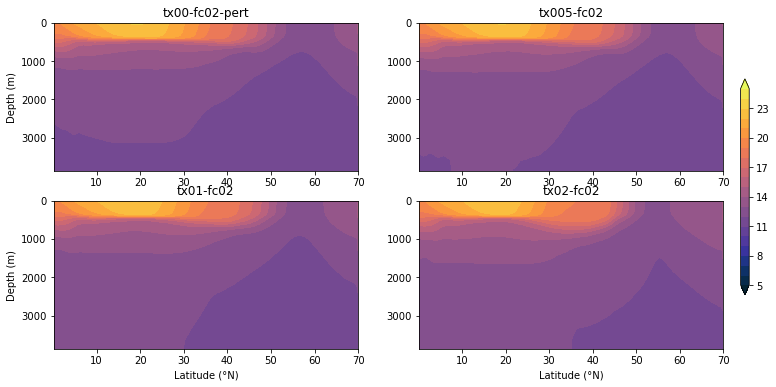

In [23]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
vlev = np.linspace(5,25,21)
variable = 'temp'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_zonally_averaged.nc'
    temp = xr.open_dataset(FileName).temp
    p1 = temp.plot.contourf(ax=ax[np.int(ii/2),np.mod(ii,2)],levels=vlev,extend='both',cmap=cm.cm.thermal,add_colorbar=False)
    ax[np.int(ii/2),np.mod(ii,2)].invert_yaxis()
    ax[np.int(ii/2),np.mod(ii,2)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Depth (m)')
ax[1,0].set_ylabel('Depth (m)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5,0,'')

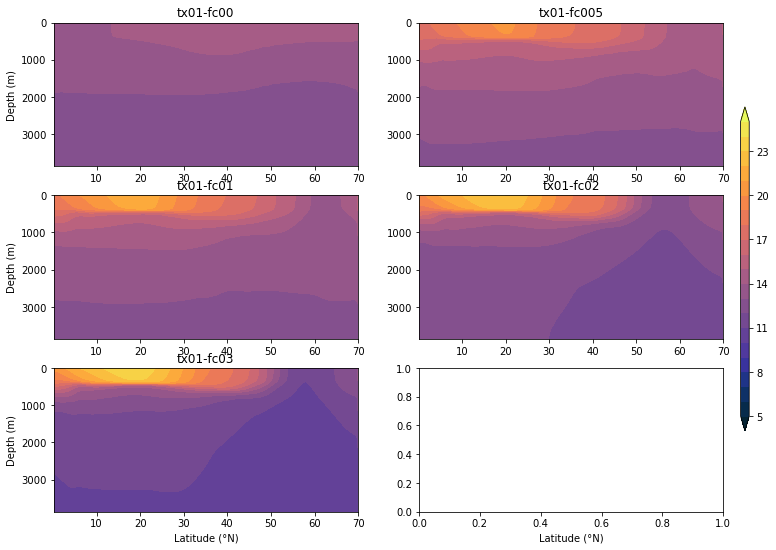

In [30]:
fig, ax = plt.subplots(3,2,figsize=(12,9))
vlev = np.linspace(5,25,21)
variable = 'temp'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_zonally_averaged.nc'
    temp = xr.open_dataset(FileName).temp
    p1 = temp.plot.contourf(ax=ax[np.int(ii/2),np.mod(ii,2)],levels=vlev,extend='both',cmap=cm.cm.thermal,add_colorbar=False)
    ax[np.int(ii/2),np.mod(ii,2)].invert_yaxis()
    ax[np.int(ii/2),np.mod(ii,2)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Depth (m)')
ax[1,0].set_ylabel('Depth (m)')
ax[2,0].set_ylabel('Depth (m)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,0].set_xlabel('Latitude (°N)')
ax[2,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')

Text(0.5,0,'')

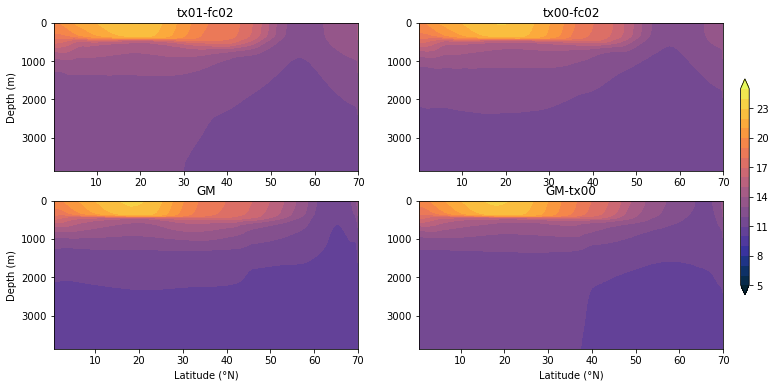

In [31]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
vlev = np.linspace(5,25,21)
variable = 'temp'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_zonally_averaged.nc'
    temp = xr.open_dataset(FileName).temp
    p1 = temp.plot.contourf(ax=ax[np.int(ii/2),np.mod(ii,2)],levels=vlev,extend='both',cmap=cm.cm.thermal,add_colorbar=False)
    ax[np.int(ii/2),np.mod(ii,2)].invert_yaxis()
    ax[np.int(ii/2),np.mod(ii,2)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Depth (m)')
ax[1,0].set_ylabel('Depth (m)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

## Upper ocean streamfunction

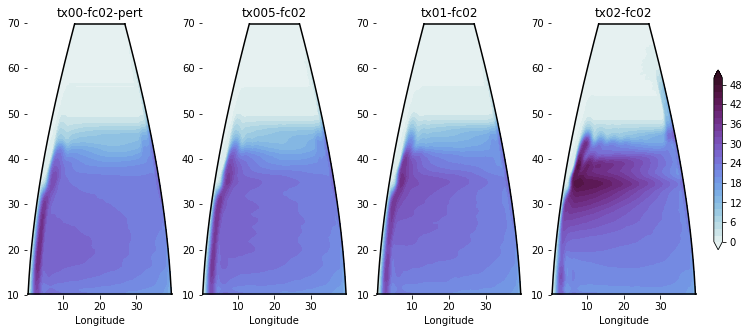

In [18]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,50,26)
ii=0
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

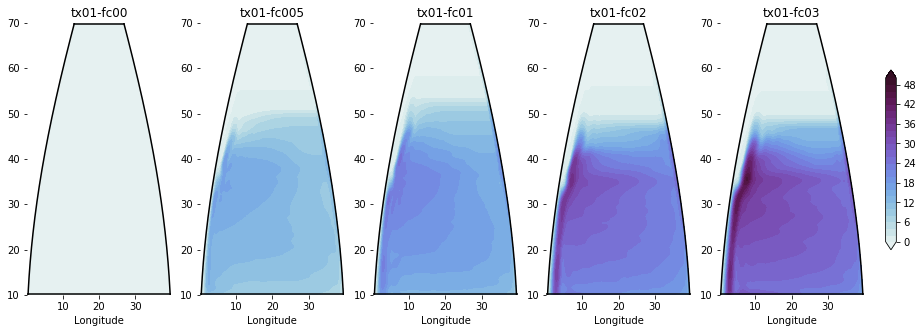

In [19]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(0,50,26)
ii=0
variable = 'vh_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

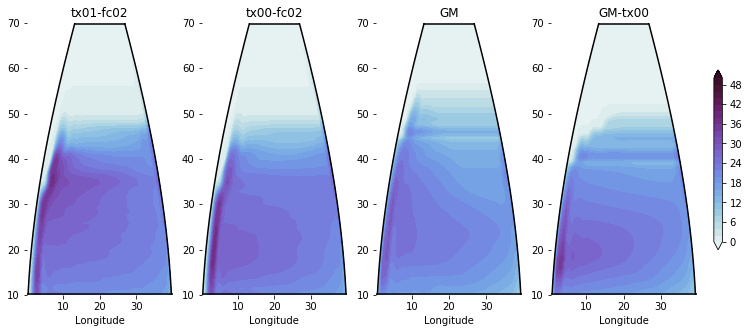

In [45]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,50,26)
ii=0
variable = 'vh_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'Upper Ocean circulation at 10°E')

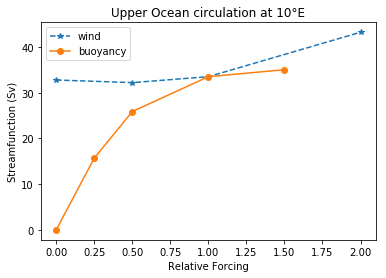

In [85]:
# subtropical gyre strength at 10°E
plt.figure(figsize=(6,4))
variable = 'vh_rho'

psivec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho.sel(xh=10,method='nearest').max()
    psivec = np.append(psivec,psi)
plt.plot(wind,psivec,'*--',label='wind')  
         

psivec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho.sel(xh=10,method='nearest').max()
    psivec = np.append(psivec,psi)
plt.plot(buoyancy,psivec,'o-',label='buoyancy')  

plt.legend()
plt.ylabel('Streamfunction (Sv)')
plt.xlabel('Relative Forcing')
plt.title('Upper Ocean circulation at 10°E')


Text(0.5,1,'(c) GM Expts')

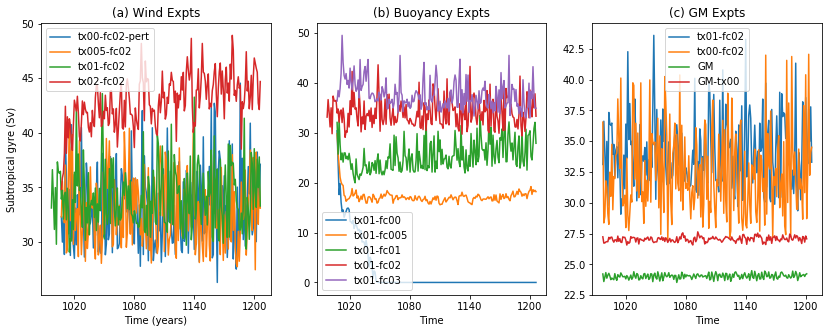

In [82]:
plt.figure(figsize=(14,5))
variable = 'vh_rho'
plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)  
plt.legend()
plt.ylabel('Subtropical gyre (Sv)')
plt.xlabel('Time (years)')
plt.title('(a) Wind Expts')


plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(b) Buoyancy Expts')
plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(c) GM Expts')

## Lower ocean streamfunction

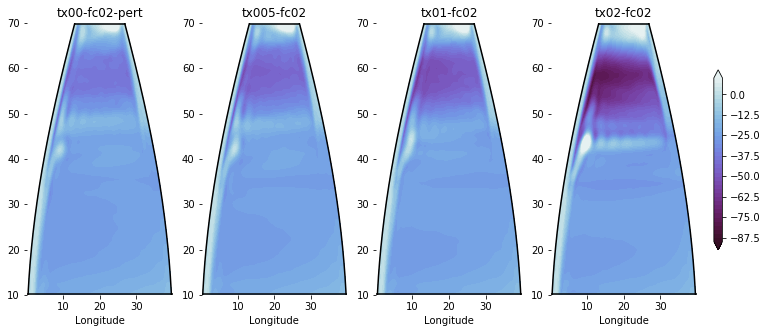

In [22]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-90,10,41)
ii=0
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense_r)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

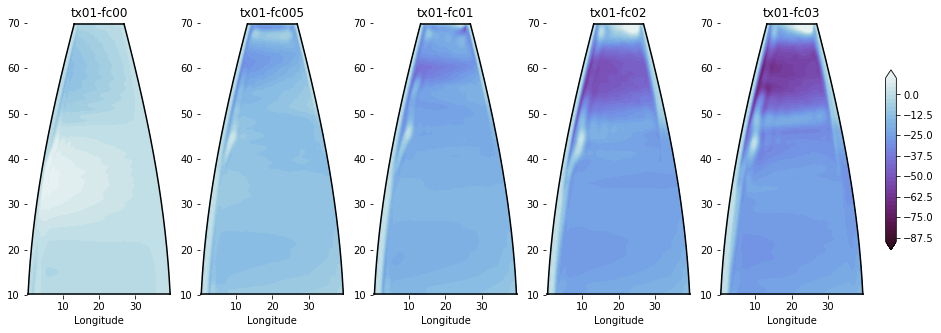

In [23]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-90,10,41)
ii=0
variable = 'vh_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense_r)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

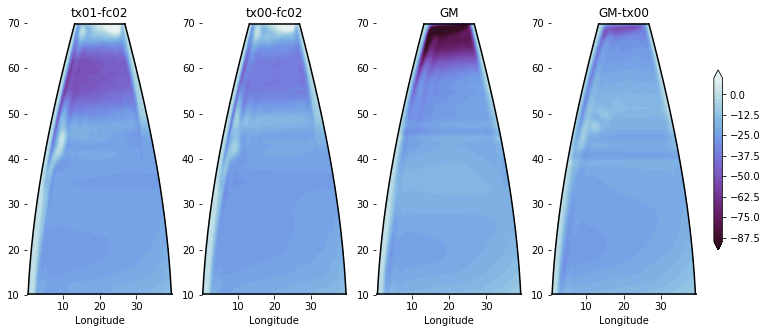

In [47]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-90,10,41)
ii=0
variable = 'vh_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense_r)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'Lower Ocean circulation at 10°E')

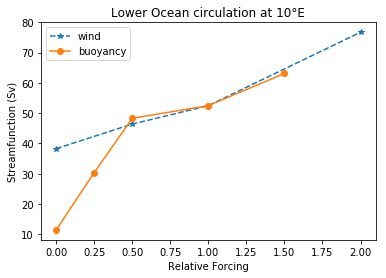

In [87]:
# subpolar gyre strength at 10°E
plt.figure(figsize=(6,4))
variable = 'vh_rho'

psivec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = -xr.open_dataset(FileName).vh_rho.sel(xh=10,method='nearest').min()
    psivec = np.append(psivec,psi)
plt.plot(wind,psivec,'*--',label='wind')  
         

psivec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = -xr.open_dataset(FileName).vh_rho.sel(xh=10,method='nearest').min()
    psivec = np.append(psivec,psi)
plt.plot(buoyancy,psivec,'o-',label='buoyancy')  

plt.legend()
plt.ylabel('Streamfunction (Sv)')
plt.xlabel('Relative Forcing')
plt.title('Lower Ocean circulation at 10°E')



Text(0.5,1,'(c) GM Expts')

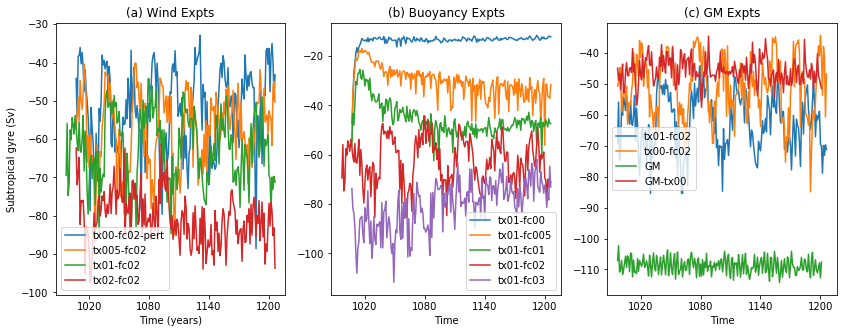

In [88]:
plt.figure(figsize=(14,5))
variable = 'vh_rho'
plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)  
plt.legend()
plt.ylabel('Subtropical gyre (Sv)')
plt.xlabel('Time (years)')
plt.title('(a) Wind Expts')


plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(b) Buoyancy Expts')

plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(c) GM Expts')

## Overturning

Text(0.5,0,'')

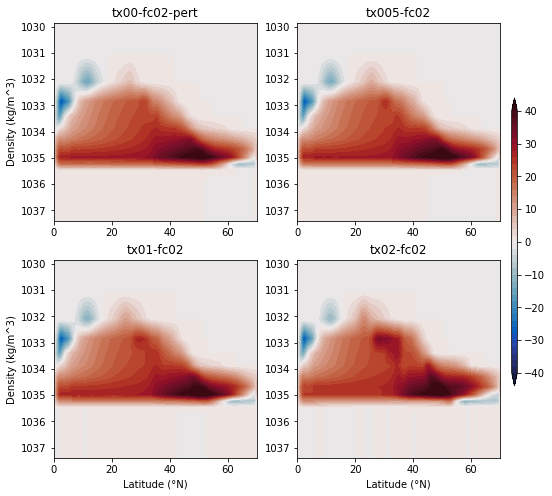

In [26]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
vlev = np.linspace(-40,40,41)
variable = 'vh_rho'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    p1 = psi.plot.contourf(ax=ax[np.int(ii/2),np.mod(ii,2)],levels=vlev,extend='both',cmap=cm.cm.balance,add_colorbar=False)
    ax[np.int(ii/2),np.mod(ii,2)].invert_yaxis()
    ax[np.int(ii/2),np.mod(ii,2)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Density (kg/m^3)')
ax[1,0].set_ylabel('Density (kg/m^3)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5,0,'')

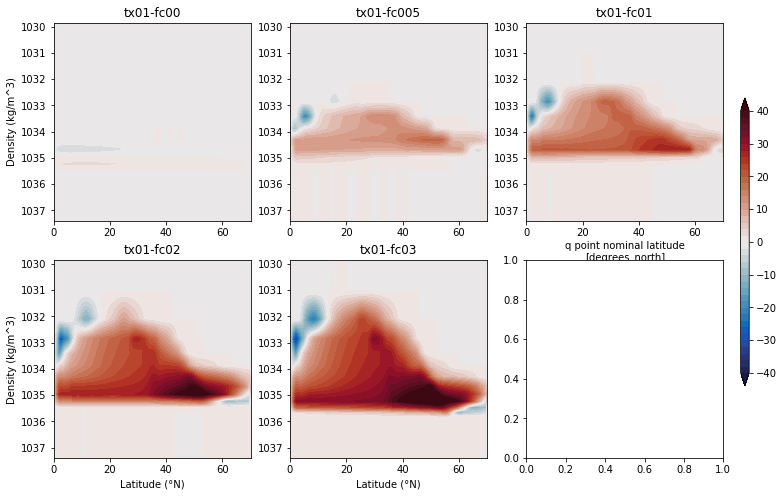

In [27]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
vlev = np.linspace(-40,40,41)
variable = 'vh_rho'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    p1 = psi.plot.contourf(ax=ax[np.int(ii/3),np.mod(ii,3)],levels=vlev,extend='both',cmap=cm.cm.balance,add_colorbar=False)
    ax[np.int(ii/3),np.mod(ii,3)].invert_yaxis()
    ax[np.int(ii/3),np.mod(ii,3)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Density (kg/m^3)')
ax[1,0].set_ylabel('Density (kg/m^3)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5,0,'')

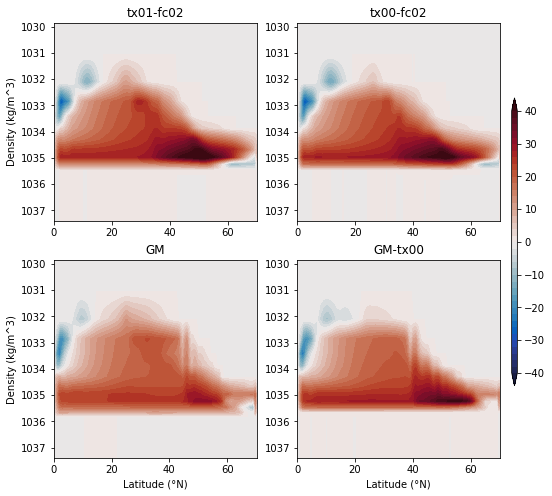

In [49]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
vlev = np.linspace(-40,40,41)
variable = 'vh_rho'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    p1 = psi.plot.contourf(ax=ax[np.int(ii/2),np.mod(ii,2)],levels=vlev,extend='both',cmap=cm.cm.balance,add_colorbar=False)
    ax[np.int(ii/2),np.mod(ii,2)].invert_yaxis()
    ax[np.int(ii/2),np.mod(ii,2)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Density (kg/m^3)')
ax[1,0].set_ylabel('Density (kg/m^3)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5,1,'Overturning circulation')

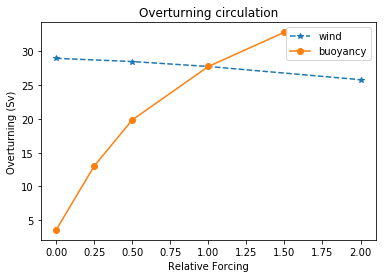

In [91]:
# Overturning circulation from 20-30°N
plt.figure(figsize=(6,4))
variable = 'vh_rho'

OCvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho.mean()
    OCvec = np.append(OCvec,psi)
plt.plot(wind,OCvec,'*--',label='wind')  


OCvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho.mean()
    OCvec = np.append(OCvec,psi)
plt.plot(buoyancy,OCvec,'o-',label='buoyancy')  

plt.legend()
plt.ylabel('Overturning (Sv)')
plt.xlabel('Relative Forcing')
plt.title('Overturning circulation')



Text(0.5,1,'(c) GM Expts')

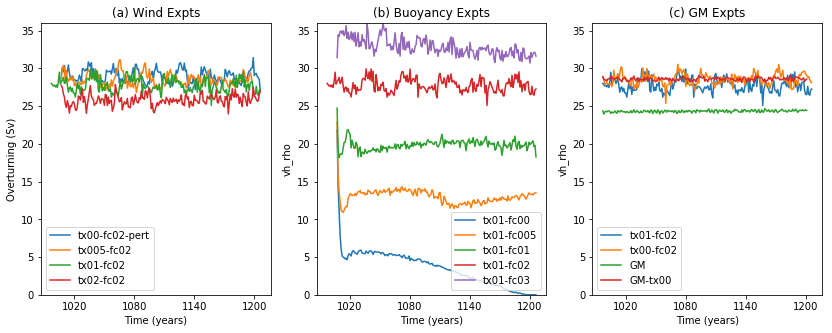

In [90]:
plt.figure(figsize=(14,5))
variable = 'vh_rho'

plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.ylim(ymin=0,ymax=36)
plt.legend()
plt.ylabel('Overturning (Sv)')
plt.xlabel('Time (years)')
plt.title('(a) Wind Expts')

plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)     
plt.ylim(ymin=0,ymax=36)
plt.legend()
plt.xlabel('Time (years)')
plt.title('(b) Buoyancy Expts')

plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.ylim(ymin=0,ymax=36)
plt.legend()
plt.xlabel('Time (years)')
plt.title('(c) GM Expts')

## Barotropic streamfunction

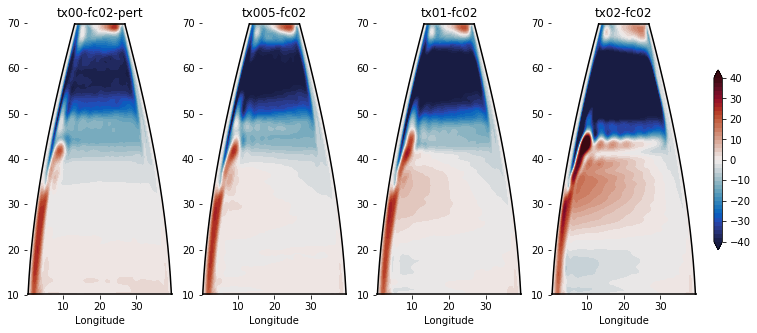

In [30]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-40,40,41)
ii=0
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

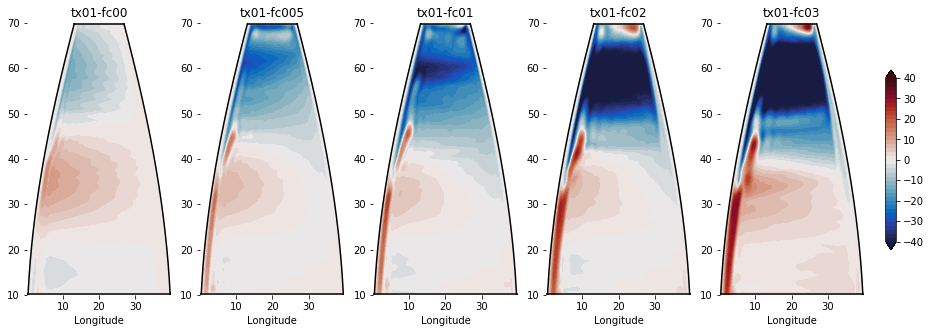

In [31]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-40,40,41)
ii=0
variable = 'vh_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

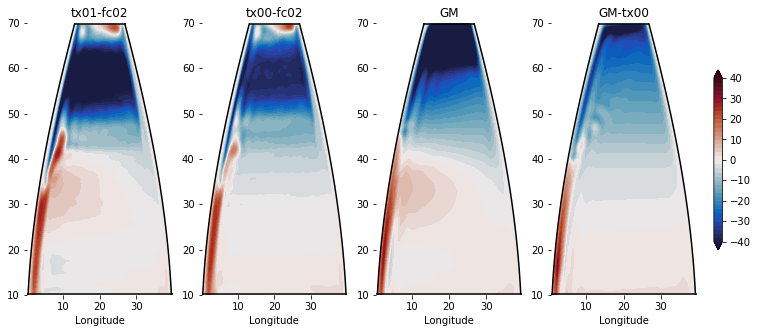

In [51]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-40,40,41)
ii=0
variable = 'vh_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(b) Subtropical Barotropic circulation')

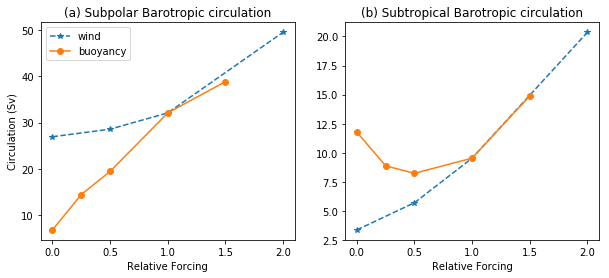

In [95]:
# Barotropic circulation at 10°E
plt.figure(figsize=(10,4))
plt.subplot(121)
variable = 'vh_rho'

BCvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psi = - xr.open_dataset(FileName).vh_rho.mean()
    BCvec = np.append(BCvec,psi)
plt.plot(wind,BCvec,'*--',label='wind')  


BCvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psi = - xr.open_dataset(FileName).vh_rho.mean()
    BCvec = np.append(BCvec,psi)
plt.plot(buoyancy,BCvec,'o-',label='buoyancy')  

plt.legend()
plt.ylabel('Circulation (Sv)')
plt.xlabel('Relative Forcing')
plt.title('(a) Subpolar Barotropic circulation')


plt.subplot(122)
variable = 'vh_rho'

BCvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho.mean()
    BCvec = np.append(BCvec,psi)
plt.plot(wind,BCvec,'*--',label='wind')  


BCvec=np.array([])
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho.mean()
    BCvec = np.append(BCvec,psi)
plt.plot(buoyancy,BCvec,'o-',label='buoyancy')  

plt.ylabel('')
plt.xlabel('Relative Forcing')
plt.title('(b) Subtropical Barotropic circulation')

Text(0.5,1,'(f) GM Expts: $\\psi_{BT}$ Maximum')

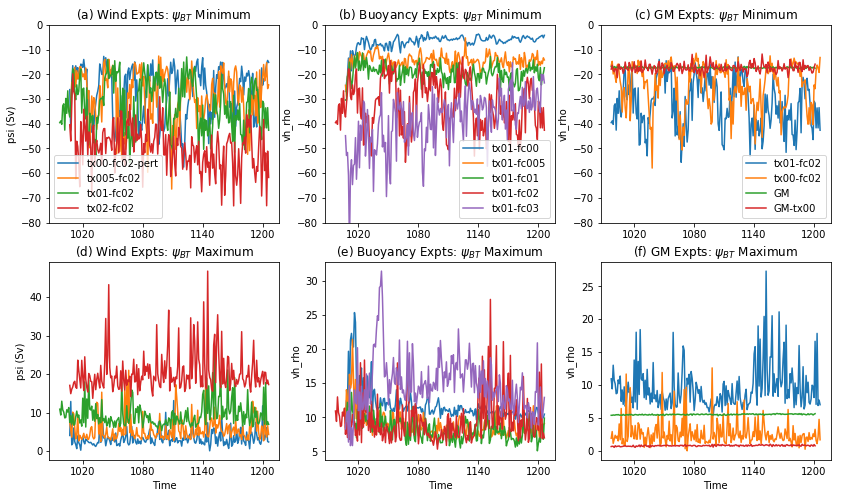

In [93]:
fig,ax = plt.subplots(2,3,figsize=(14,8))
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin = xr.open_dataset(FileName).vh_rho
    psimin.plot(ax=ax[0,0], label=ekey)
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psimax = xr.open_dataset(FileName).vh_rho
    psimax.plot(ax=ax[1,0], label=ekey)
                
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin = xr.open_dataset(FileName).vh_rho
    psimin.plot(ax=ax[0,1], label=ekey)
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psimax = xr.open_dataset(FileName).vh_rho
    psimax.plot(ax=ax[1,1], label=ekey)
                
                
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin = xr.open_dataset(FileName).vh_rho
    psimin.plot(ax=ax[0,2], label=ekey)
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psimax = xr.open_dataset(FileName).vh_rho
    psimax.plot(ax=ax[1,2], label=ekey)

ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[0,0].set_ylim(ymin=-80,ymax=0)
ax[0,1].set_ylim(ymin=-80,ymax=0)
ax[0,2].set_ylim(ymin=-80,ymax=0)
ax[0,0].set_ylabel('psi (Sv)')
ax[1,0].set_ylabel('psi (Sv)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,0].set_title('(a) Wind Expts: $\psi_{BT}$ Minimum')
ax[0,1].set_title('(b) Buoyancy Expts: $\psi_{BT}$ Minimum')
ax[0,2].set_title('(c) GM Expts: $\psi_{BT}$ Minimum')
ax[1,0].set_title('(d) Wind Expts: $\psi_{BT}$ Maximum')
ax[1,1].set_title('(e) Buoyancy Expts: $\psi_{BT}$ Maximum')
ax[1,2].set_title('(f) GM Expts: $\psi_{BT}$ Maximum')

## Stratification

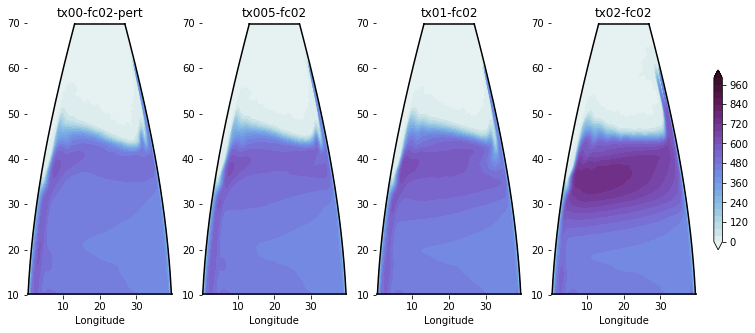

In [35]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,1000,26)
ii=0
variable = 'h_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_1034_averaged.nc'
    h = xr.open_dataset(FileName).h_rho
    X,Y = plot_mercator(ax[ii],h.coords['xh'],h.coords['yh'])
    p1=ax[ii].contourf(X,Y,h,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

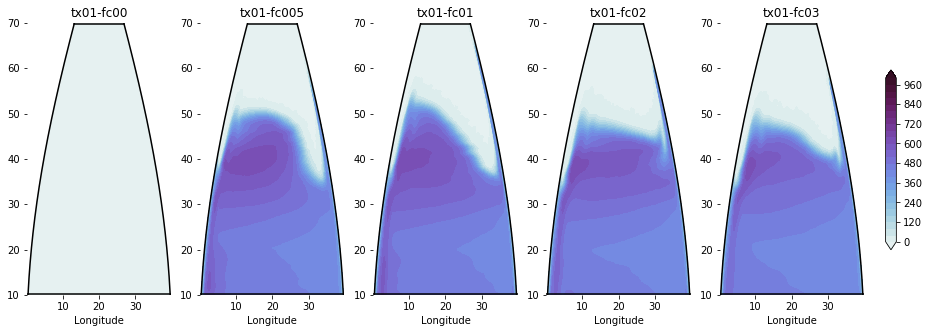

In [36]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(0,1000,26)
ii=0
variable = 'h_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_1034_averaged.nc'
    h = xr.open_dataset(FileName).h_rho
    X,Y = plot_mercator(ax[ii],h.coords['xh'],h.coords['yh'])
    p1=ax[ii].contourf(X,Y,h,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

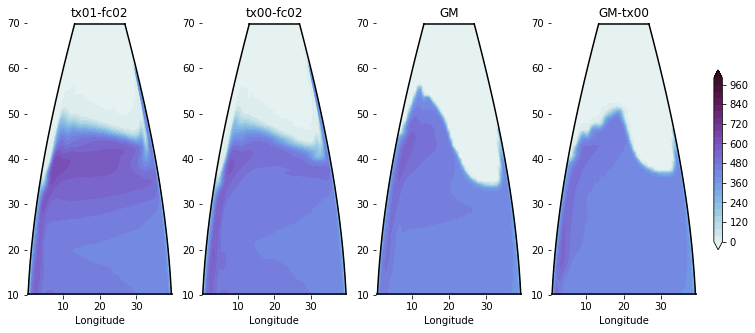

In [53]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,1000,26)
ii=0
variable = 'h_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_1034_averaged.nc'
    h = xr.open_dataset(FileName).h_rho
    X,Y = plot_mercator(ax[ii],h.coords['xh'],h.coords['yh'])
    p1=ax[ii].contourf(X,Y,h,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)